# IMPORT LIBRARIES AND DATASET

In [203]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import random 

import os
import cv2
#import gdown
#from zipfile import ZipFile
from tensorflow.keras import layers
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras import Model
import gc
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
#import h5py
from keras.models import load_model
# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)


In [144]:
#os.makedirs("celeba_gan")
#pip install gdown

In [145]:
#os.makedirs("celeba_gan")

#url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
#url = "https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip"
#output = "celeba_gan/data.zip"
#gdown.download(url, output, quiet=True)

#with ZipFile("celeba_gan/data.zip", "r") as zipobj:
#    zipobj.extractall("celeba_gan")

In [146]:
folder = 'C:/Users/user/Desktop/CELEBA/img_align_celeba/'
samples = os.listdir(folder)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2372ac8be20>)

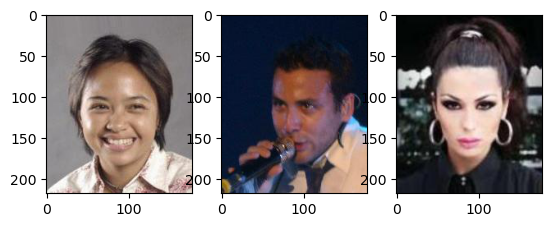

In [147]:
folder = 'C:/Users/user/Desktop/CELEBA/img_align_celeba/'
samples = os.listdir(folder)
#print(samples)

img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(132), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(133), plt.imshow(img)

In [148]:
#size = 64 
# new size 178×218
x, y = [],[]
t= []
i=0
for sample in tqdm(samples):
    i=i +1
    if i > 701:
        break
    img = cv2.cvtColor(cv2.imread(os.path.join(folder, sample)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    if i > 500:
        t.append(img)
    if i < 701:  
        x.append(img)
  

  0%|          | 701/202599 [00:01<05:05, 659.92it/s]


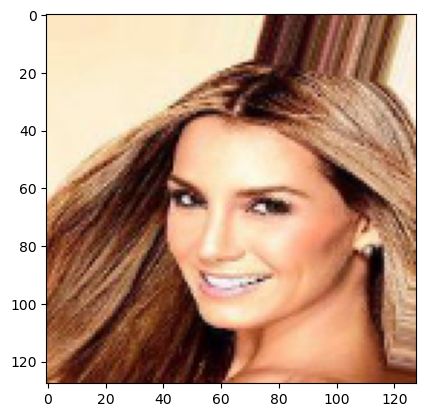

In [149]:
plt.imshow(x[0])

# Preprocessing data

In [150]:
X_train = np.array(x)/255

del x
gc.collect()

X_test = np.array(t)/255

del t
gc.collect()


0

In [151]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.044
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [152]:
noise_factor = 0.3

noise_dataset = []

for img in X_train:
  #noisy_image = img + noise_factor * np.random.randn(*img.shape)
  noisy_image = noisy("s&p" ,img)
  noisy_image = np.clip(noisy_image, 0., 1.)
  noise_dataset.append(noisy_image)

C:\Users\user\AppData\Local\Temp\ipykernel_11632\3595669891.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_11632\3595669891.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


In [153]:
noise_dataset = np.array(noise_dataset)
noise_dataset.shape

(700, 128, 128, 3)

In [ ]:
plt.imshow(noise_dataset[22], cmap="gray")
gc.collect()

In [155]:
noise_test_set = []
for img in X_test:
  #noisy_image = img + noise_factor * np.random.randn(*img.shape)
  noisy_image = noisy("s&p" ,img)
  noisy_image = np.clip(noisy_image, 0., 1.)
  noise_test_set.append(noisy_image)
  
noise_test_set = np.array(noise_test_set)
noise_test_set.shape

C:\Users\user\AppData\Local\Temp\ipykernel_11632\3595669891.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_11632\3595669891.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


(201, 128, 128, 3)

In [186]:
import pickle

#noise_dataset X_train
#noise_test_set X_test
#train_dataloader = Dataloder(noise_dataset,X_train, batch_size, shuffle=True)
#test_dataloader = Dataloder(noise_test_set,X_test,batch_size, shuffle=True)
#train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
#test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)


noise_dataset, X_train = pickle.load(open('E:/Downloads/ImageDenoising-main/train_data.pkl', 'rb'))
noise_test_set,X_test = pickle.load(open('E:/Downloads/ImageDenoising-main/test_data.pkl', 'rb'))

#Normalizing the image pixels
noise_dataset = noise_dataset.reshape(-1, 128, 128, 3).astype("float32") / 255.0
X_train = X_train.reshape(-1, 128, 128, 3).astype("float32") / 255.0
noise_test_set = noise_test_set.reshape(-1, 128, 128, 3).astype("float32") / 255.0
X_test = X_test.reshape(-1, 128, 128, 3).astype("float32") / 255.0

In [156]:
gc.collect()

#Custom function to plot/visualize noisy, ground truth and predicted images
def visualize(sample,model):
  fig,ax = plt.subplots(len(sample),3,figsize=(30,30))
  for i in range(len(sample)):
    path = sample['Ground Truth Images'].iloc[i]
    test_img_gt = cv2.imread(path)
    test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
    test_img_gt = cv2.resize(test_img_gt,(512,512))
    test_img_gt = test_img_gt.astype("float32") / 255.0
  
    path = sample['Noisy Images'].iloc[i]
    test_img_nsy = cv2.imread(path)
    pred_img = prediction(test_img_nsy,model)
    pred_img = cv2.resize(pred_img,(512,512))

    test_img_nsy = cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
    test_img_nsy = cv2.resize(test_img_nsy,(512,512))
    test_img_nsy = test_img_nsy.astype("float32") / 255.0
    
    ax[i][0].imshow(test_img_nsy)
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][0].title.set_text("Noisy Image")

    ax[i][1].imshow(test_img_gt)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    ax[i][1].title.set_text("Ground Truth Image")

    ax[i][2].imshow(pred_img)
    ax[i][2].get_xaxis().set_visible(False)
    ax[i][2].get_yaxis().set_visible(False)
    ax[i][2].title.set_text("Predicted Image")

BUILD AND TRAIN AUTOENCODER DEEP LEARNING MODEL

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.”

In [183]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [200]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'


tf.keras.backend.clear_session()
input = tf.keras.layers.Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu",kernel_initializer='he_normal', padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(3, (3, 3), activation="sigmoid", kernel_initializer='he_normal',padding="same")(x)


autoencoder = Model(input, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError(), metrics=["accuracy"])
autoencoder.summary()

#autoencoder = tf.keras.models.Model


#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
#decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)






Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856 

In [198]:
#autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))

batch_size=32
#noise_dataset X_train
#noise_test_set X_test
train_dataloader = Dataloder(noise_dataset,X_train, batch_size, shuffle=True)
test_dataloader = Dataloder(noise_test_set,X_test,batch_size, shuffle=True)

log_dir="C:/Users/user/Desktop/CELEBA/logs/model_1"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1,verbose=1,patience=2)
callback = [tensorboard,reducelr]
history = autoencoder.fit(train_dataloader,shuffle=True,epochs=1,validation_data= test_dataloader, callbacks=callback)


#autoencoder.save('C:/Users/user/Desktop/CELEBA/autoencoder.h5')
#autoencoder =  tf.keras.models.load_model('C:/Users/user/Desktop/CELEBA/autoencoder.h5')

512/512 [==============================] - 399s 779ms/step - loss: 0.0086 - val_loss: 0.0071 - lr: 0.0010


KeyError: 'accuracy'

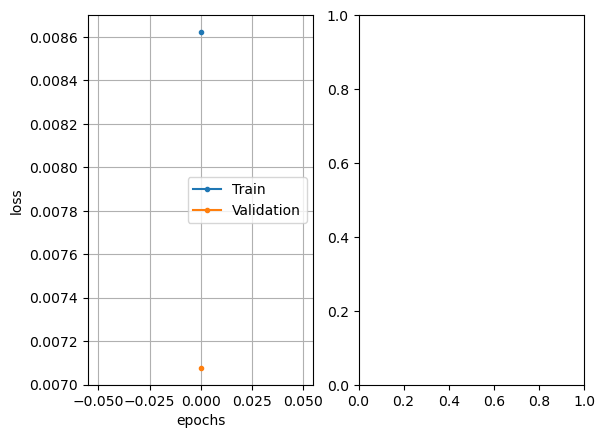

In [199]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

In [ ]:
#autoencoder.fit(noise_dataset, X_train,
#                epochs=15,
#                batch_size=32,
#                shuffle=True,
#                validation_data=(noise_test_set, X_test))

In [ ]:
#autoencoder.fit(noise_dataset.reshape(-1, 128, 128, 3),          
#                X_train.reshape(-1, 128, 128, 3), 
#                epochs=25, 
#                batch_size=200, 
#                validation_data=(noise_test_set.reshape(-1, 128, 128, 3), X_test.reshape(-1, 128, 128, 3)))


 EVALUATE TRAINED MODEL PERFORMANCE

In [202]:
evaluation = autoencoder.evaluate(noise_test_set.reshape(-1, 128, 128, 3), X_test.reshape(-1, 128, 128, 3))
print('Test Accuracy : {:.3f}'.format(evaluation))

128/128 [==============================] - 26s 197ms/step - loss: 0.1001 - accuracy: 0.0985


TypeError: unsupported format string passed to list.__format__

In [201]:
predicted = autoencoder.predict(noise_test_set[:10].reshape(-1, 128, 128, 3))

1/1 [==============================] - 0s 156ms/step


In [ ]:
blured_test_set = []
for img in noise_test_set:
  blured_image = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
  blured_test_set.append(blured_image)
  
blured_test_set = np.array(blured_test_set)
blured_test_set.shape

(4096, 128, 128, 3)

In [ ]:
predicted.shape

(10, 128, 128, 3)

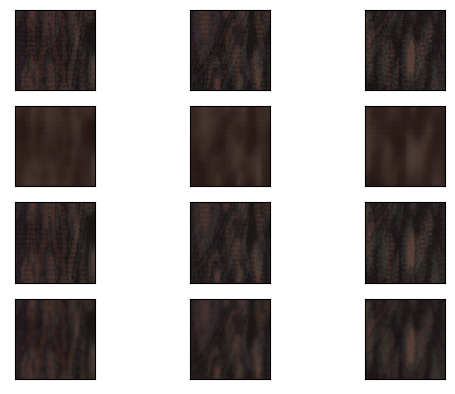

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True)
for images, row in zip([noise_test_set[:3], predicted, X_test, blured_test_set], axes):
    for img, ax in zip(images, row):
        #ax.imshow(img.reshape((128, 64)))
        ax.imshow(img.reshape(128, 128, 3))        
        #ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

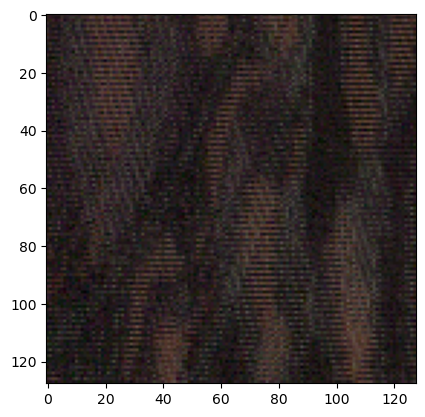

In [ ]:
plt.imshow(noise_test_set[1])

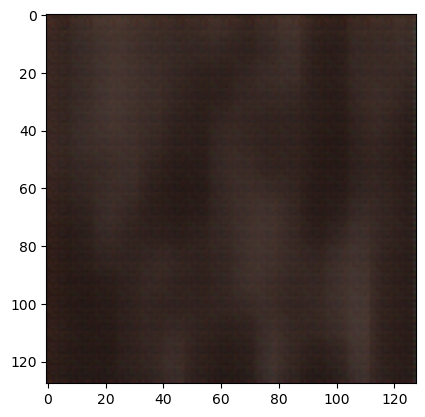

In [ ]:
plt.imshow(predicted[1])

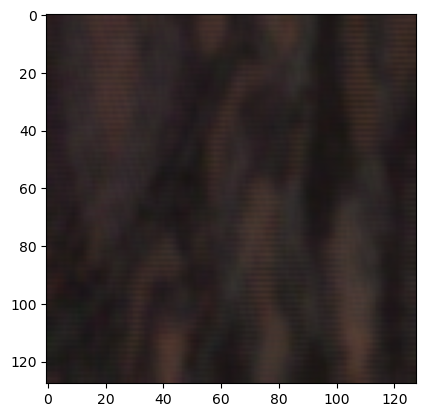

In [ ]:
plt.imshow(blured_test_set[1])

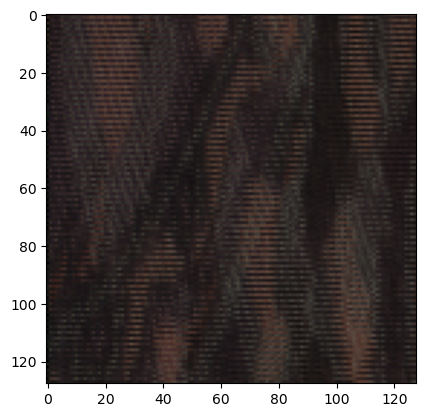

In [ ]:
plt.imshow(X_test[1])

As the result, it makes sense to use convolutional neural networks as encoders and decoders. However, the convolutional autoencoders generate a very blured version of the original image.

Compared to the Gaussian bluring, the results with convolutional networks are in my opinion better in case of heavy noice. 

In case of not buch noice on the images, it is most likely better to use Gaussian bluring.

Tested noise type: salt&pepper, poisson, speckle